Here, our mission is to basically check if investing in solar panels will be profitable for the company.

In [1]:
# Install LightGBM for predicting daily energy prices
!pip install lightgbm

In [2]:
from typing import Tuple

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import sem
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [3]:
def load_data(data_path):
    df=pd.read_csv(data_path)
    mapping_columns = {"RRP":"price", "demand_pos_RRP":"demand_pos_price", "RRP_positive":"price_positive", "demand_neg_RRP":"demand_neg_price", "RRP_negative":"price_negative", "frac_at_neg_RRP":"frac_neg_price"}
    df.rename(columns = mapping_columns, inplace = True)
    
    #Converting datatypes
    df.date = pd.to_datetime(df.date)
    df.school_day = df.school_day.map({"N": False, "Y":True}).astype('bool')
    df.holiday = df.holiday.map({"N": False, "Y":True}).astype('bool')
    
    #Extracting year, month and day of the week
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['dow'] = df.date.dt.day_of_week
    df['week'] = df.date.dt.isocalendar().week.astype('int')
    
    #We convert solar exposure from MJ/m^2 to MWh/m^2 because the units of the other columns use MWh 
    df.solar_exposure = df.solar_exposure/3600
    
    #This is in order to be able to do resampling later on
    df.set_index('date', inplace = True)
    
    return df

In [4]:
df = load_data('https://raw.githubusercontent.com/KamgangAnthony/Predicting-Electricity-Price-Levels-/main/complete_dataset.csv')

How did prices change throughout the years?

Three main events

Although the price is affected by other events too, the main ones that have made it shift throughout these years are outlined below.

### Hazelwood coal factory decommissioned

- <a href="https://en.wikipedia.org/wiki/Hazelwood_Power_Station">The hazelwood coal station</a> was closed in an effort by the country to transition to more enviromental friendly energy sources of electricity. 
- This made the price of electricity to step up.

### Australia experiences temperature peaks

- <a href="https://wattclarity.com.au/articles/2019/01/my-first-look-at-the-highs-and-lows-in-victoria-and-south-australia-on-thursday-24th-january-2019/">The country</a> experienced it's highest temperatures at least since 2015 during this period. 
- This has made electricity demand rise and surely prices too(see demand and price correlation down). 
- Demand rises because people use electricity to cool themselves(through air conditioning for example).

### The corona virus makes prices fall more

- Although prices had already started to decline a little, the pandemic has further increased it's downfall.

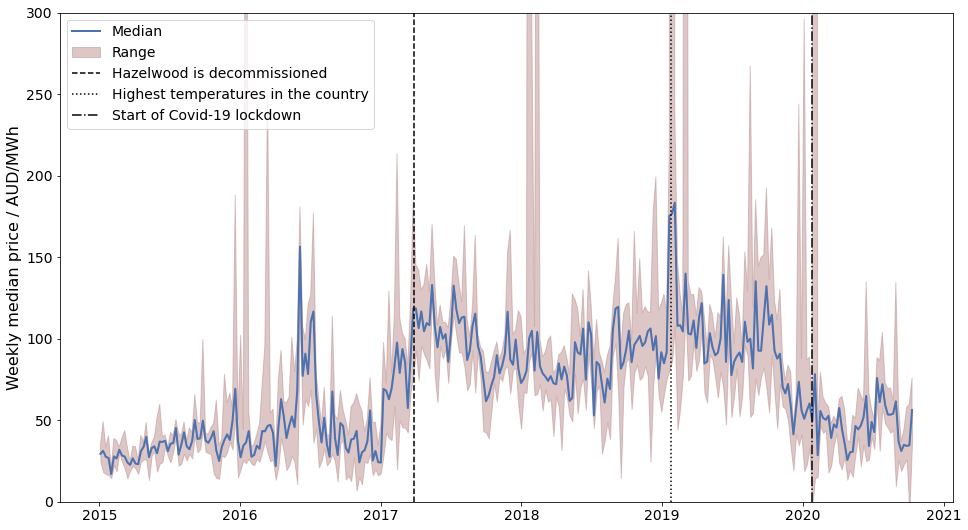

In [5]:
fig, ax = plt.subplots()
interval = '1W'
weekly_median = df.resample(interval).price.median()
weekly_max = df.resample(interval).price.max()
weekly_min = df.resample(interval).price.min()
weekly_mad = df.resample(interval).price.mad()
weekly_std = df.resample(interval).price.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.5, color = 'rosybrown', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.5,  color = 'rosybrown')

ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood is decommissioned')
ax.axvline(pd.Timestamp('2019-1-24'), ls = ':', c = 'k', label = 'Highest temperatures in the country')
ax.axvline(pd.Timestamp('2020-1-25'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

ax.set_ylabel('Weekly median price / AUD/MWh')
ax.set_ylim([0, 300])
ax.legend()

Average price from 2017-2019:<br>
     We start from 2017 because it is at that time that the Hazelwood factory was decommissioned. 
    It changed the price significantly so we use the new price level instead.

In [6]:
print(f"Mean price from 2017 to 2019: {df['2017-01-01':'2019-12-31'].price.mean():.1f} AUD/MWh")

Mean price from 2017 to 2019: 102.2 AUD/MWh


## Seasonal variation in prices
### Variation in demand
The plot below shows the seasonal variation in demand for electricity. The average demand is highest during the Australian winter (peaking around June and July), presumbaly due to electrical heating. The highest peak demand, however, is during the summer on very hot days where the need for air conditioning causes a surge.

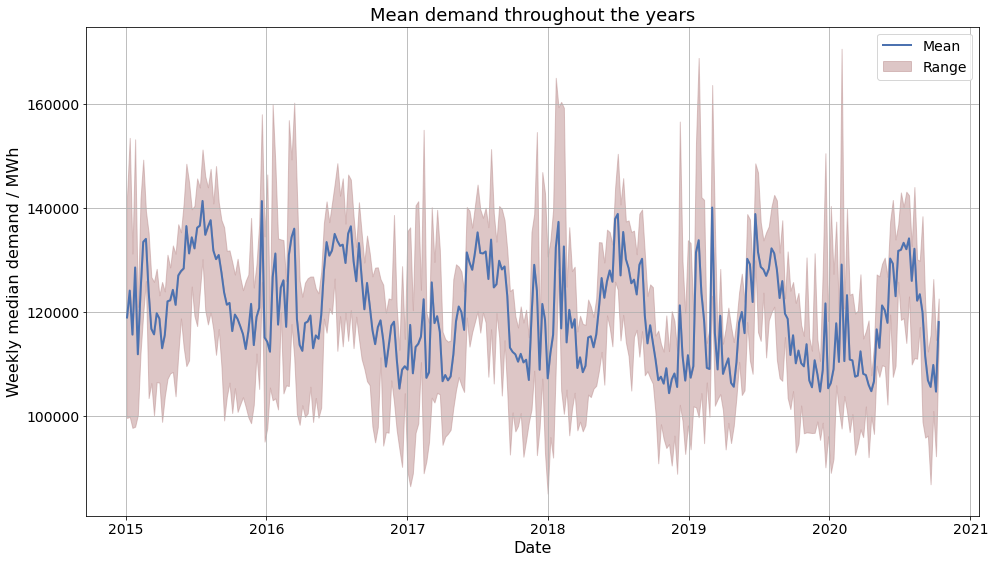

In [7]:
fig, ax = plt.subplots()
interval = '1W'
weekly_median = df.resample(interval).demand.mean()
weekly_max = df.resample(interval).demand.max()
weekly_min = df.resample(interval).demand.min()
weekly_std = df.resample(interval).demand.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.5, color = 'rosybrown', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.5,  color = 'rosybrown')

ax.set_title('Mean demand throughout the years')
ax.set_ylabel('Weekly median demand / MWh')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

### Correlation between demand and price

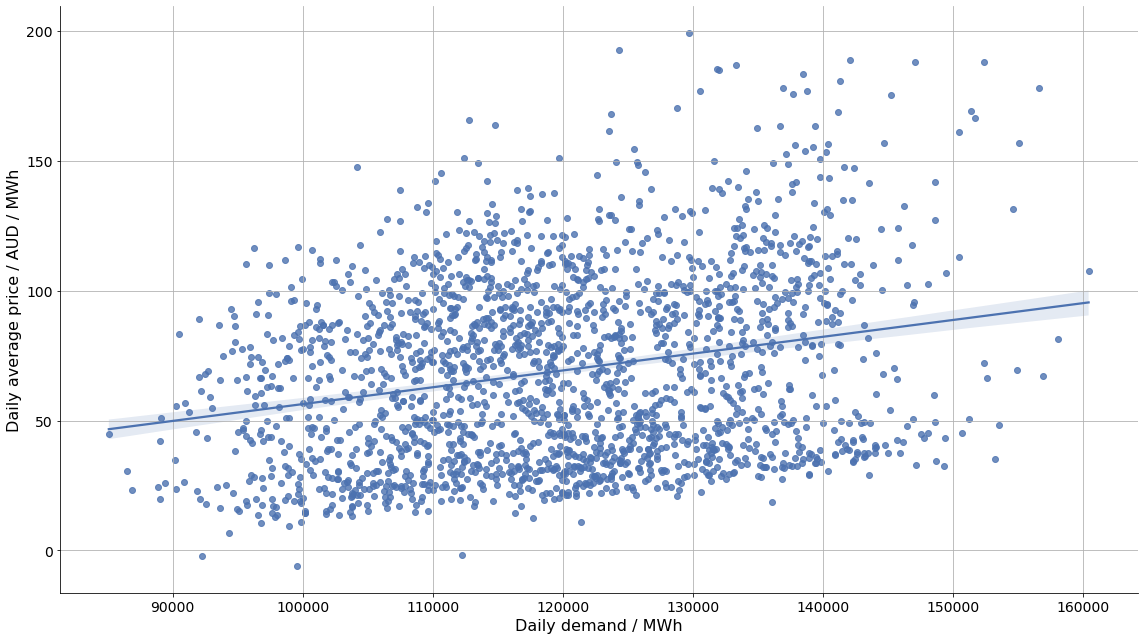

In [8]:
grid = sns.lmplot(data = df[df.price < df.price.median()*3], x = 'demand', y = 'price', height = 9, aspect = 16/9)
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

Patterns in prices per seasons and months of the year.

### Variation in average price per month 
According to this graph, the prices in January(<a href="http://www.bom.gov.au/climate/glossary/seasons.shtml">the hot summer</a>) should be greater than during the rest of the year. Let's not forget that Australia had it's greatest temperatures in January 2019 and these have affected this graph.

<p>We can say that during the months of:</p>
<p style="text-indent:10px">January(Summer season in general)</p>
<p style="text-indent:10px">July and August(Winter season in general)</p><br>
prices will usually rise. <br>
<br>
Because electricity is being heavily used to cool down or heat up living spaces according to the season.

Text(0, 0.5, 'Relative average price per month')

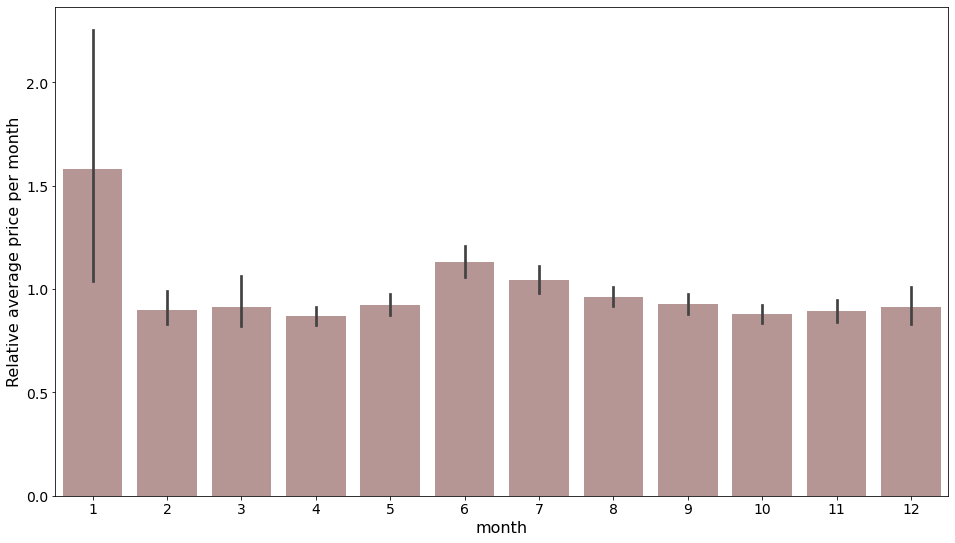

In [9]:
yearly_means = df.groupby('year').price.mean().to_frame('mean_yearly_price')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_means, on = 'year')
df_temp['relative_price'] = df_temp.price/df_temp.mean_yearly_price

ax = sns.barplot(data = df_temp, y = 'relative_price', x = 'month', estimator = np.mean, color = 'rosybrown')
ax.set_ylabel('Relative average price per month')

### Solar exposure over time
- In the middle of the year during the winter, solar exposure is lowest.
- Vice versa, solar exposure is highest during summer.

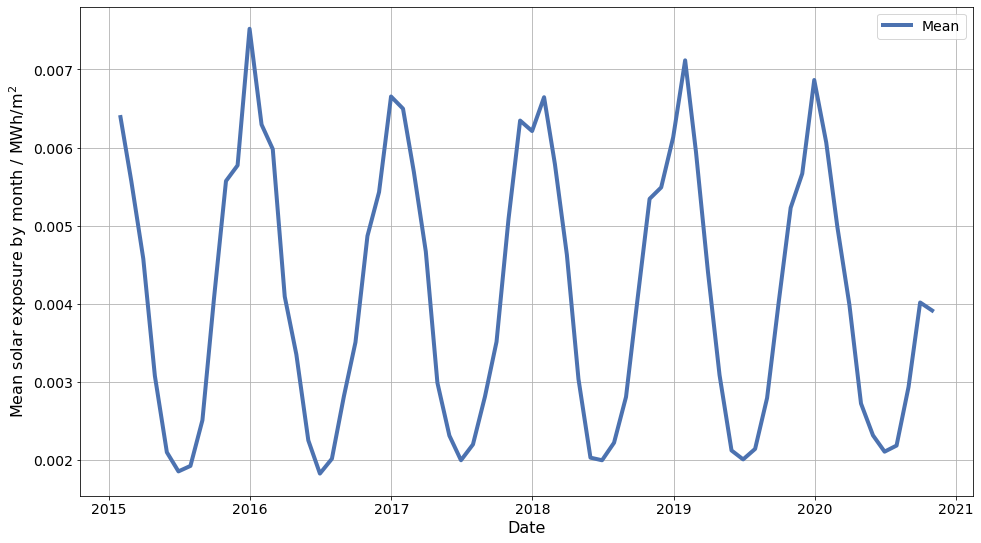

In [10]:
fig, ax = plt.subplots()
sample_window = '1M'
weekly_mean = df.resample(sample_window).solar_exposure.mean()
weekly_max = df.resample(sample_window).solar_exposure.max()
weekly_min = df.resample(sample_window).solar_exposure.min()

ax.plot(weekly_mean.index, weekly_mean, lw = 4, label = 'Mean')

ax.set_ylabel(r'Mean solar exposure by month / MWh/m$^2$')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

Now let's calculate the average value of the electricity produced by a solar array, making the following assumptions:
- Using the prices for 2017-2019 (inclusive)
- Solar array is functional 100% of the time
- All of the electricity is sold at the average daily price (solar power peaks at midday while prices may not so this assumption is probably not true)

The average value of the electricity produced by a solar array is slightly more than the yearly average price since it is mostly produced in the summer where we have peaks in demand: 108.9 AUD/MWh vs 102.2 AUD/MWh.

In [11]:
df_1719 = df['2017-01-01':'2019-12-31']

weighted_average_price = (df_1719.solar_exposure * df_1719.price).sum()/df_1719.solar_exposure.sum()

print(f"Weighted average value of electricity produced by solar array: {weighted_average_price:.1f} AUD/MWh")

Weighted average value of electricity produced by solar array: 108.9 AUD/MWh


## Return on investment
Given that a solar array produces electricity valued at 108.9 AUD/MWh on average, is it actually worth building solar arrays? And how long would it take for a solar array to pay back for itself?

Let's start by calculating the value of the electricity per unit area generated by the solar array over a year:

In [12]:
avg_price = 108.9
PV_efficiency = 0.2
electricity_values = df[df.year != 2020].groupby('year').solar_exposure.sum()*PV_efficiency*avg_price
mean_profit, error_in_mean = electricity_values.mean(), electricity_values.sem()

print(f"Assuming projected average price of {avg_price:.1f} AUD/MWh and solar cell efficiency of {PV_efficiency*100:.1f}%"
      f", mean yearly profit for 2015-2019 is {mean_profit:.1f} +/- {error_in_mean:.1f} AUD/m^2")

Assuming projected average price of 108.9 AUD/MWh and solar cell efficiency of 20.0%, mean yearly profit for 2015-2019 is 33.3 +/- 0.2 AUD/m^2


I can buy a 0.715 m x 0.810 m panel from [HomeDepot](https://images.thdstatic.com/catalog/pdfImages/d3/d30b0bf3-e332-4ba8-852f-80aedabf1c70.pdf) for around $100. Presumably you get a discount if you're buying in bulk so let's say you get a generous 50% discount. The price per square meter is then

In [13]:
discount = 0.5
price = 100
length = 0.810
width = 0.715
panel_cost = (1-discount)*price/(length*width)
print(f"Solar panel cost estimate: {panel_cost:.1f} AUD/m^2")


Solar panel cost estimate: 86.3 AUD/m^2


and the ROI is

In [14]:
mean_profit

33.306097

In [15]:
print(f"Yearly ROI: {mean_profit/panel_cost*100:.1f} %")

Yearly ROI: 38.6 %


Based on this, a solar array in Melbourne is a great investment. The ROI above does not take into account installation and maintenance costs, or the degradation of the solar panels over time. With these factors included, the costs may go up significantly, and the efficiency of the panels will also lower over time, resulting in smaller profits. However, taking the lifetime of a solar panel to be [25-30 years](https://news.energysage.com/how-long-do-solar-panels-last/), they will have ample time to pay back for themselves (around 10 years, even if we triple the cost per square meter assumed here). 